In [69]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
import json
import seaborn as sns
import re
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nyt-articles-data/df_1949.csv
/kaggle/input/nyt-articles-data/df_1944.csv
/kaggle/input/nyt-articles-data/df_1973.csv
/kaggle/input/nyt-articles-data/df_1992.csv
/kaggle/input/nyt-articles-data/df_2018.csv
/kaggle/input/nyt-articles-data/df_1930.csv
/kaggle/input/nyt-articles-data/df_2016.csv
/kaggle/input/nyt-articles-data/df_1999.csv
/kaggle/input/nyt-articles-data/df_1996.csv
/kaggle/input/nyt-articles-data/df_1979.csv
/kaggle/input/nyt-articles-data/df_2009.csv
/kaggle/input/nyt-articles-data/df_1966.csv
/kaggle/input/nyt-articles-data/df_1926.csv
/kaggle/input/nyt-articles-data/df_1978.csv
/kaggle/input/nyt-articles-data/df_2019.csv
/kaggle/input/nyt-articles-data/df_2011.csv
/kaggle/input/nyt-articles-data/df_2005.csv
/kaggle/input/nyt-articles-data/df_1955.csv
/kaggle/input/nyt-articles-data/df_1985.csv
/kaggle/input/nyt-articles-data/df_2014.csv
/kaggle/input/nyt-articles-data/df_1991.csv
/kaggle/input/nyt-articles-data/df_1986.csv
/kaggle/input/nyt-articles-data/

Скрипт, целью которого является сбор данных через API NY Times заголовков статей и выдержек за временной промежуток с 1920 по 2020 год:

In [ ]:
df_bag_of_sentence = {}

for year in range(1921, 2021):
    bag_of_sentence = []
    for month in range(1, 13):
        articles_request = requests.get(f'https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key=kqUfZjUcBrYxAuOcQFteCDFAGCbeMMJm')
        if articles_request.ok:
            articles_content = json.loads(articles_request.text)
            number_of_news_items = len(articles_content['response']['docs'])

            for i in range(number_of_news_items):
                if 'abstract' in articles_content['response']['docs'][i].keys():
                    fragment_abstract = articles_content['response']['docs'][i]['abstract']
                    fragment_headline = articles_content['response']['docs'][i]['headline']['main']
                    if fragment_abstract or fragment_headline:
                        fragment = fragment_abstract + ' ' + fragment_headline
                    bag_of_sentence.append(fragment)
                    
    df_bag_of_sentence = pd.DataFrame(data=bag_of_sentence, index=np.full_like(range(len(bag_of_sentence)), year))
    df_bag_of_sentence = df_bag_of_sentence.reset_index()
    df_bag_of_sentence.rename(columns={'index': 'year', 0: 'sentence'}, inplace=True)
    df_bag_of_sentence.to_csv(f'datasets\df_{year}.csv')

In [3]:
sentence_year = pd.DataFrame()

for year in range(1920, 2021):
    df = pd.read_csv(f'/kaggle/input/nyt-articles-data/df_{year}.csv')
    sentence_year = pd.concat([sentence_year, df])

Получили следующий файл, где Year - это год выхода публикации, а Sentence - это объединенные заголовок и выдержка (изображение ниже):

![](https://clip2net.com/clip/m593032/32ae2-clip-53kb.png?nocache=1)

In [4]:
sentence_year.drop(columns=['Unnamed: 0'], inplace=True)
sentence_year

,year,sentence
0,1920,"ROME, Jan. 2.--It is of the utmost importance ..."
1,1920,FIND GIRL AND DOG DEAD.; Candy Near Bodies in...
2,1920,There was opened yesterday in the Art Departme...
3,1920,Free Champagne at the Vanderbilt.
4,1920,"20 Seized at Portland, Ore."
...,...,...
69114,2020,"During his rally in Newtown, Pa., on Saturday,..."
69115,2020,A magnitude-7.0 quake that struck in the Aegea...
69116,2020,Former President Barack Obama on Saturday join...
69117,2020,Prime Minister Boris Johnson announced expansi...


In [5]:
X = sentence_year['sentence']
y = sentence_year['year']

С целью улучшения качества модели было принято решение разделить временной промежуток на 10 частей:

In [6]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
y = discretizer.fit_transform(np.array(y).reshape(-1,1))

Посмотрим на распределение таргета (есть небольшой дисбаланс): 

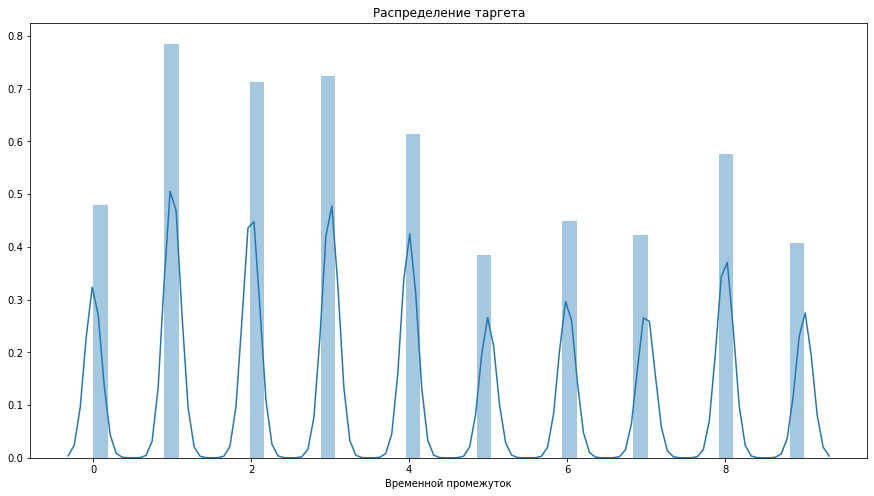

In [11]:
plt.figure(figsize=(15,8))

sns.distplot(y)

plt.title('Распределение таргета')
plt.xlabel('Временной промежуток')
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

Воспользовася TfidfVectorizer для того, чтобы представить текст в векторном виде:

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfvec = TfidfVectorizer(min_df = 0.00001, stop_words='english', token_pattern='\\b[A-z][A-z][A-z]+\\b')
tfvec.fit(X_train)

X_train_vec = tfvec.transform(X_train)
X_test_vec = tfvec.transform(X_test)

In [126]:
X_train_vec.shape, X_test_vec.shape # 0

((8685456, 55822), (8685457, 55822))

Обучим предсказательную модель для дискретных величин, где таргетом будет являться временной промежуток:

In [127]:
from sklearn.naive_bayes import MultinomialNB

y_train = y_train.ravel()
y_test = y_test.ravel()

mnb_clf = MultinomialNB()
mnb_clf.fit(X_train_vec, y_train)

mnb_clf.score(X_train_vec, y_train), mnb_clf.score(X_test_vec, y_test)

(0.4991579025902612, 0.4899335751705408)

In [128]:
from sklearn.naive_bayes import BernoulliNB

bnb_clf = BernoulliNB()
bnb_clf.fit(X_train_vec, y_train)

bnb_clf.score(X_train_vec, y_train), bnb_clf.score(X_test_vec, y_test)

(0.4717937664988459, 0.46605883835473483)

Достанем словарь, на котором обучалась наша модель:

In [129]:
tfvec_voc = np.array(sorted(tfvec.vocabulary_.items(), key=lambda x: x[1]))[:, 0]
tfvec_voc

array(['___', '____', '_____', ..., 'zwirner', 'zydeco', 'zynga'],
      dtype='<U22')

Файл **EmotionLookupTable.txt** (http://sentistrength.wlv.ac.uk/ первоначально задумывалось, что воспользуюсь готовым модулем, но он оказался платным) с размеченными словами с позитивным и негативным окрасом, где каждому из слов присуждается численный балл со знаком + или -:

In [130]:
emotion_words = pd.read_csv('../input/emotion-words/EmotionLookupTable.txt', sep='\t', names=['word', 'score'])
emotion_words

,word,score
0,abandon*,-2.0
1,abate,-2.0
2,abdicate*,-2.0
3,abhor*,-4.0
4,abject,-2.0
...,...,...
2540,yays,3.0
2541,yearn*,-2.0
2542,yelp,-2.0
2543,zest*,2.0


С помощью данного кода берем наиболее важные слова (основанные на коэффициентах в модели) и считаем по ним neg_score и pos_score по файлу emotion_words.

In [150]:
year_scores = {}

ind_year = mnb_clf.coef_.shape[0]

for i in range(ind_year):

    best_words_by_year = pd.DataFrame(data=np.c_[tfvec_voc, mnb_clf.coef_[i]], columns=['word', 'coeff'])
    best_words_by_year = best_words_by_year.astype({'coeff': 'float64', 'word': 'str'})
    best_words_by_year = best_words_by_year[best_words_by_year.coeff > np.quantile(best_words_by_year.coeff, 0.99)]
    str_best_words_by_year = ' '.join(best_words_by_year['word'].unique())

    neg_score = 0
    pos_score = 0

    for word, score in emotion_words.values:

        if word.endswith('*'):
            match_pattern = re.search(f'[ ]?\\b{word[:-1]}\\w+\\b', str_best_words_by_year)
        else:
            match_pattern = re.search(f'[ ]?\\b{word}\\b', str_best_words_by_year)

        if match_pattern and score < 0:
            match_word = match_pattern.group(0)
            neg_score += abs(score)
            str_best_words_by_year = str_best_words_by_year.replace(match_word, '')
        elif match_pattern and score > 0:
            match_word = match_pattern.group(0)
            pos_score += score
            str_best_words_by_year = str_best_words_by_year.replace(match_word, '')
    
    year_scores[i] = [neg_score, pos_score]

In [151]:
year_scores

{0: [43.0, 25.0],
 1: [33.0, 23.0],
 2: [34.0, 16.0],
 3: [36.0, 18.0],
 4: [33.0, 14.0],
 5: [40.0, 21.0],
 6: [28.0, 22.0],
 7: [33.0, 26.0],
 8: [34.0, 35.0],
 9: [41.0, 30.0]}

In [156]:
    best_words_by_year = pd.DataFrame(data=np.c_[tfvec_voc, mnb_clf.coef_[i]], columns=['word', 'coeff'])
    best_words_by_year = best_words_by_year.astype({'coeff': 'float64', 'word': 'str'})
    best_words_by_year = best_words_by_year[best_words_by_year.coeff > np.quantile(best_words_by_year.coeff, 0.99)]
best_words_by_year.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 559 entries, 299 to 55562
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   word    559 non-null    object 
 1   coeff   559 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.1+ KB


In [152]:
year_interval = np.array(y_train)
year_interval

array([7., 7., 4., ..., 1., 7., 8.])

In [153]:
neg_scores = np.array(list(year_scores.values()))[:, 0]
pos_scores = np.array(list(year_scores.values()))[:, 1]

In [154]:
neg_scores / sum(neg_scores + pos_scores) * 100
pos_scores / sum(neg_scores + pos_scores) * 100

array([4.27350427, 3.93162393, 2.73504274, 3.07692308, 2.39316239,
       3.58974359, 3.76068376, 4.44444444, 5.98290598, 5.12820513])

Построим итоговый график:

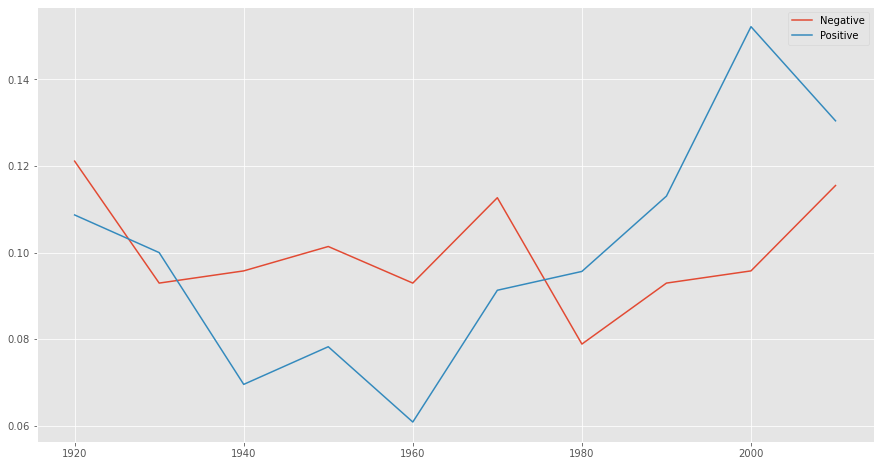

In [155]:
plt.figure(figsize=(15,8))

sns.lineplot(list(range(1920, 2019, 10)), neg_scores / sum(neg_scores), label='Negative')
sns.lineplot(list(range(1920, 2019, 10)), pos_scores / sum(pos_scores), label='Positive')


plt.legend()
plt.title('')
plt.show()

Убедимся, что график выше не корелирует с суммарной длиной и средней длиной анализируемых предложений:

In [47]:
sentence_year['size_sentence'] = sentence_year['sentence'].apply(lambda x: len(x))

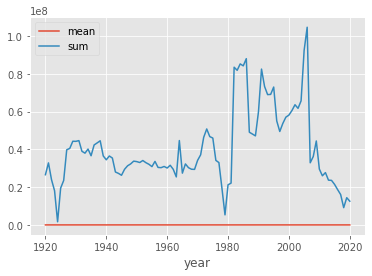

In [73]:
sentence_year.groupby('year')['size_sentence'].agg(['mean', 'sum']).plot()